In [2]:
from pyspark.sql import SparkSession

In [5]:
spark = SparkSession.builder.appName("session1").getOrCreate()

In [12]:
df = spark.read.csv("stayforlong_bookings.csv",header=True)

In [23]:
df.columns

['hotel',
 'is_canceled',
 'booking_to_arrival_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'board',
 'country',
 'market_segment',
 'acquisition_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'reserved_room_type',
 'assigned_room_type',
 'booking_changes',
 'deposit_type',
 'agent',
 'company',
 'days_in_waiting_list',
 'customer_type',
 'adr',
 'parking_lot',
 'total_of_special_requests',
 'reservation_status',
 'reservation_status_date']

In [53]:
##TEMPORAL VIEW AS HOTELS
df.createOrReplaceTempView("hotels")

[Row(country='SOM', counter=48590)]

In [ ]:
##FIRST ATTRIBUTE
##TEMPORAL VIEW AS A COUNTER OF COUNTRY PER HOTEL
df2 = spark.sql("SELECT count(country) as counter,country from hotels group by country")
df2.createOrReplaceTempView("countries_count")
##Now we use the same view to represent the value
df3 = spark.sql("SELECT country,counter from countries_count where counter=(select max(counter) from countries_count)")
df3.collect()

In [70]:
##SECOND ATTRIBUTE
##WE ASSUME THE PRICE PER NIGHT IS THE ADR VALUE AS THE DESCRIPTION TELLS THAT, I DO NOT KNOW IF ANY OTHER CALCULATION NEEDS TO BE DONE AS IT STATES THAT IT IS THE PRICE PRORRATED FOR
#df.show()
df.select("adr").show(truncate=False)

+------+
|adr   |
+------+
|77.29 |
|75    |
|109   |
|162   |
|117   |
|62.8  |
|132.6 |
|125.1 |
|75    |
|99    |
|76.5  |
|110   |
|65    |
|206.78|
|72.75 |
|160   |
|114.2 |
|74.8  |
|65    |
|121.5 |
+------+
only showing top 20 rows



In [183]:
from pyspark.sql.functions import concat, col, lit, when
##THIRD ATTRIBUTE
df_month_as_number = df.withColumn("month_num", 
      when(df.arrival_date_month == "January","01").
      when(df.arrival_date_month == "February","02").
      when(df.arrival_date_month == "March","03").
      when(df.arrival_date_month == "April","04").
      when(df.arrival_date_month == "May","05").
      when(df.arrival_date_month == "June","06").
      when(df.arrival_date_month == "July","07").
      when(df.arrival_date_month == "August","08").
      when(df.arrival_date_month == "September","09").
      when(df.arrival_date_month == "October","10").
      when(df.arrival_date_month == "November","11").
      when(df.arrival_date_month == "December","12").
      otherwise("0"))
df_day_as_date = df_month_as_number.withColumn("day_formatted", 
      when(df.arrival_date_day_of_month == "1","01").
      when(df.arrival_date_day_of_month == "2","02").
      when(df.arrival_date_day_of_month == "3","03").
      when(df.arrival_date_day_of_month == "4","04").
      when(df.arrival_date_day_of_month == "5","05").
      when(df.arrival_date_day_of_month == "6","06").
      when(df.arrival_date_day_of_month == "7","07").
      when(df.arrival_date_day_of_month == "8","08").
      when(df.arrival_date_day_of_month == "9","09").otherwise(df.arrival_date_day_of_month))
df2=df_day_as_date.withColumn("date",concat(col("arrival_date_year"),lit("-"),col("month_num"),lit("-"),col("day_formatted")))
df2.createOrReplaceTempView("hotels_formated_dates")
###we create a view for further usage
df2.createOrReplaceTempView("hotels_with_date")
df2.collect()
df_price_per_day= spark.sql("select sum(adr)/count(1) as cost_per_day,hotel,date from hotels_with_date group by hotel,date order by date")
df_price_per_day.show(100)

+------------------+---------+----------+
|      cost_per_day|    hotel|      date|
+------------------+---------+----------+
| 90.29372093023255|Apartment|2015-07-01|
| 94.20886075949367|    Hotel|2015-07-01|
| 64.45244897959184|    Hotel|2015-07-02|
| 101.9759090909091|Apartment|2015-07-02|
|             73.97|    Hotel|2015-07-03|
|106.46824999999998|Apartment|2015-07-03|
|101.78479999999999|Apartment|2015-07-04|
| 64.26315789473684|    Hotel|2015-07-04|
|           66.4875|    Hotel|2015-07-05|
| 105.9608888888889|Apartment|2015-07-05|
|            66.491|    Hotel|2015-07-06|
|106.43777777777777|Apartment|2015-07-06|
|           107.006|Apartment|2015-07-07|
|  66.0042105263158|    Hotel|2015-07-07|
|104.47310344827586|Apartment|2015-07-08|
| 62.24249999999999|    Hotel|2015-07-08|
| 64.18260869565218|    Hotel|2015-07-09|
|102.92470588235294|Apartment|2015-07-09|
|120.59500000000001|Apartment|2015-07-10|
| 71.87555555555556|    Hotel|2015-07-10|
|122.46048780487803|Apartment|2015

In [192]:
##FORTH ATTRIBUTE
##Creation of first window function where we will group by type of hotel, calculate the guests and group by month of arrival
df_users_per_month = spark.sql("SELECT count(adults + children + babies) as guests,arrival_date_month,arrival_date_year,hotel from hotels_with_date where group by arrival_date_month,month_num,arrival_date_year,hotel order by arrival_date_year,month_num")
df_users_per_month.collect()

[Row(guests=1398, arrival_date_month='July', arrival_date_year='2015', hotel='Hotel'),
 Row(guests=1378, arrival_date_month='July', arrival_date_year='2015', hotel='Apartment'),
 Row(guests=1409, arrival_date_month='August', arrival_date_year='2015', hotel='Apartment'),
 Row(guests=2476, arrival_date_month='August', arrival_date_year='2015', hotel='Hotel'),
 Row(guests=1585, arrival_date_month='September', arrival_date_year='2015', hotel='Apartment'),
 Row(guests=3529, arrival_date_month='September', arrival_date_year='2015', hotel='Hotel'),
 Row(guests=3386, arrival_date_month='October', arrival_date_year='2015', hotel='Hotel'),
 Row(guests=1571, arrival_date_month='October', arrival_date_year='2015', hotel='Apartment'),
 Row(guests=1235, arrival_date_month='November', arrival_date_year='2015', hotel='Hotel'),
 Row(guests=1105, arrival_date_month='November', arrival_date_year='2015', hotel='Apartment'),
 Row(guests=1654, arrival_date_month='December', arrival_date_year='2015', hotel='

In [72]:
##FIFTH ATTRIBUTE
##WE ASSUME THE PRICE PER NIGHT IS THE ADR VALUE AS THE DESCRIPTION TELLS THAT, I DO NOT KNOW IF ANY OTHER CALCULATION NEEDS TO BE DONE AS IT STATES THAT IT IS THE PRICE PRORRATED FOR
df2 = spark.sql("SELECT AVG(stays_in_week_nights + stays_in_weekend_nights) as average_days,hotel from hotels group by hotel")
df2.collect()

[Row(average_days=4.318547179231153, hotel='Apartment'),
 Row(average_days=2.978141938736922, hotel='Hotel')]

# Visualization

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

## Visualization of guests per month

<AxesSubplot: xlabel='year_month'>

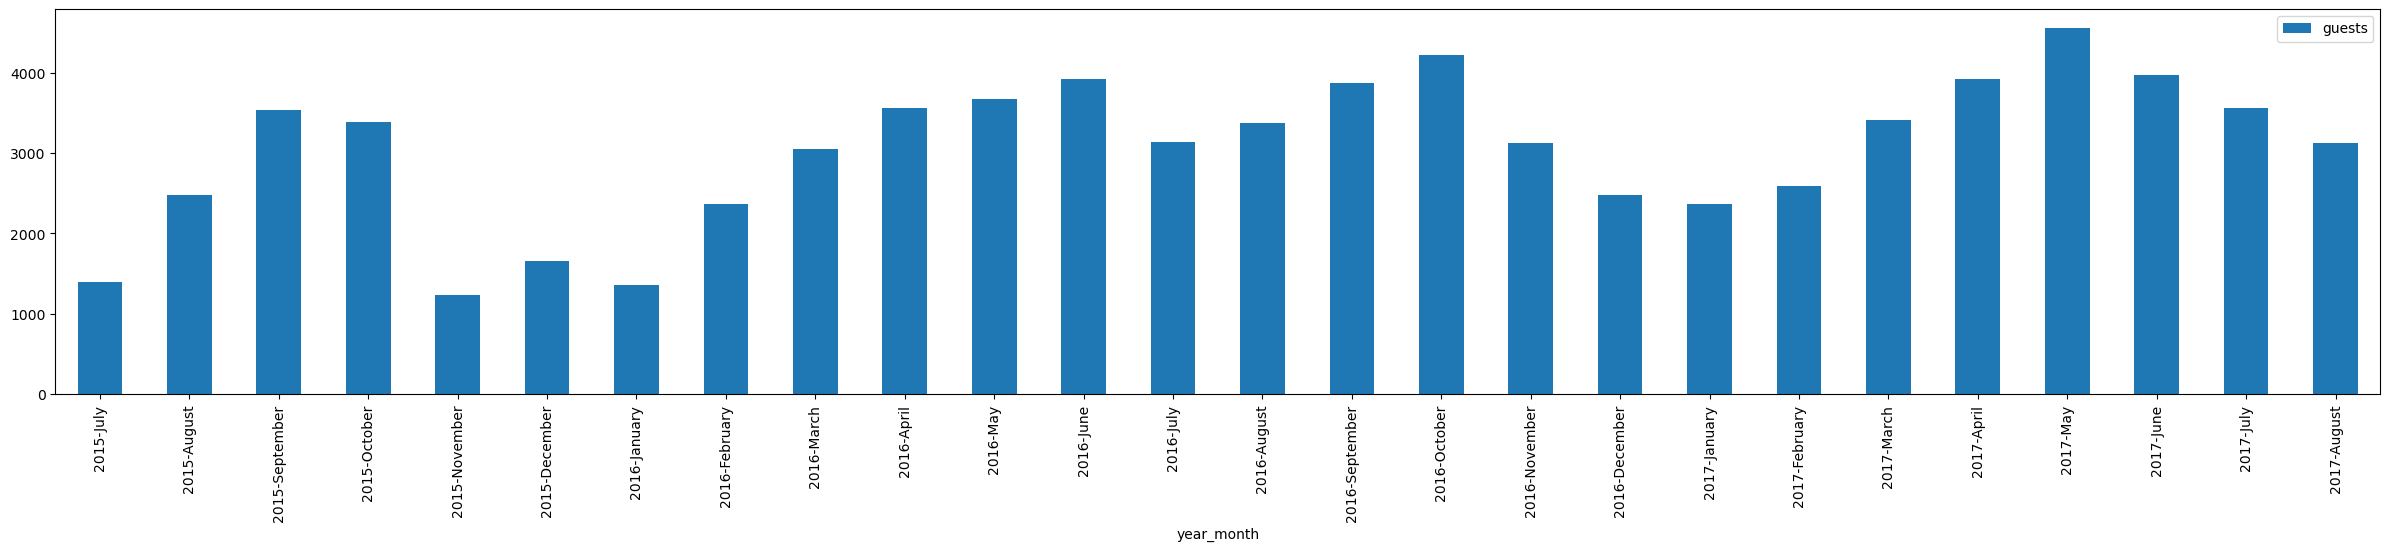

In [210]:
#First we turn into a pandas dataframe to use matplotlib
plt.rcParams["figure.figsize"] = (30,5)
df_users_per_month_pandas = df_users_per_month.toPandas()
df_users_per_month_pandas["year_month"]=df_users_per_month_pandas["arrival_date_year"].str.cat(df_users_per_month_pandas["arrival_date_month"],sep="-")
#Now we create a proper filter, we are going to split data between hotel and apartments and we are going to use only one year of data from Jan to Dec
mask = df_users_per_month_pandas["hotel"].str.contains("Hotel")
df_users_per_month_pandas_HOTEL = df_users_per_month_pandas [mask]
df_users_per_month_pandas_HOTEL.plot(kind="bar",x="year_month", y=["guests"])

## Visualization of Price per day evolution
### Comparison of 2016
We got 3 years valid of information, 2015,2016 and 2017, but the information is not complete for both 2015 and 2017, so we are going to compare 2016 to see a full cycle (we won't add more data to the graph as it is day per day and it is quite big)

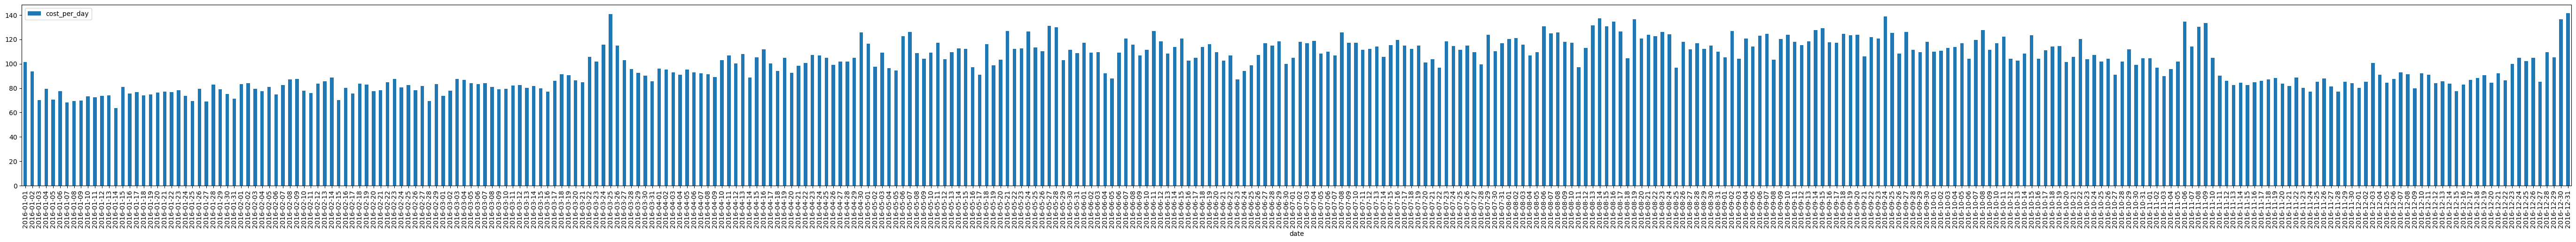

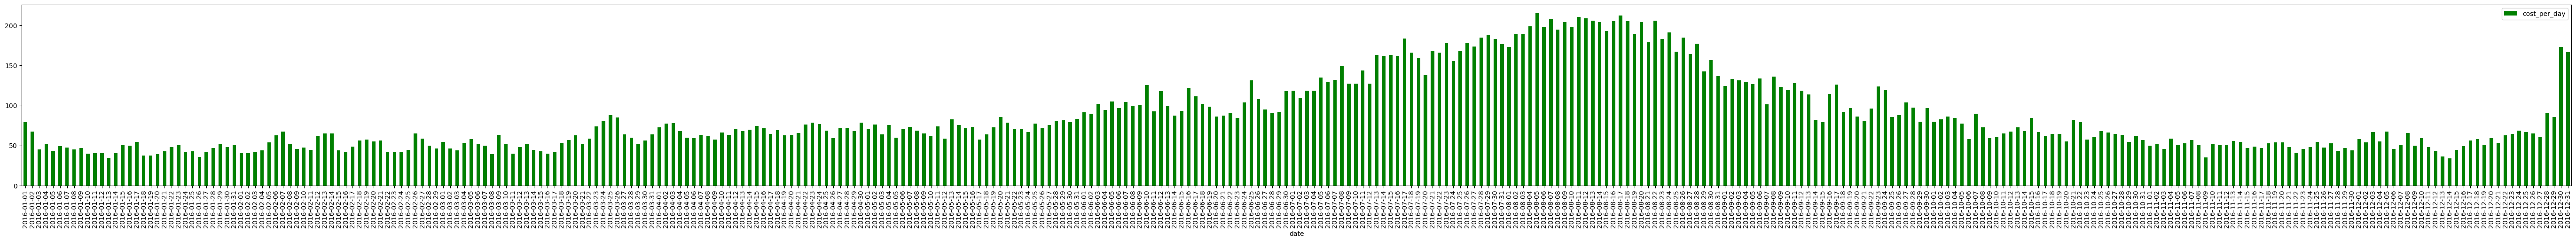

In [158]:
#First we turn into a pandas dataframe to use matplotlib
plt.rcParams["figure.figsize"] = (70,5)
df_price_per_day_pandas = df_price_per_day.toPandas()
#Now we create a proper filter, we are going to split data between hotel and apartments and we are going to use only one year of data from Jan to Dec
mask = df_price_per_day_pandas['date'].str.contains("2016") & df_price_per_day_pandas["hotel"].str.contains("Hotel")
df_price_per_day_pandas_2016 = df_price_per_day_pandas [mask]
df_price_per_day_pandas_2016.plot(kind="bar",x="date", y=["cost_per_day"])
#Now same data with Apartments
mask = df_price_per_day_pandas['date'].str.contains("2016") & df_price_per_day_pandas["hotel"].str.contains("Apartment")
df_price_per_day_pandas_2016 = df_price_per_day_pandas [mask]
df_price_per_day_pandas_2016.plot(kind="bar",x="date", y=["cost_per_day"],color='green')

plt.show()

### Comparison of 2017
We are going to see the same data but from 2017, which is incomplete, as it ends in August, but we can compare also

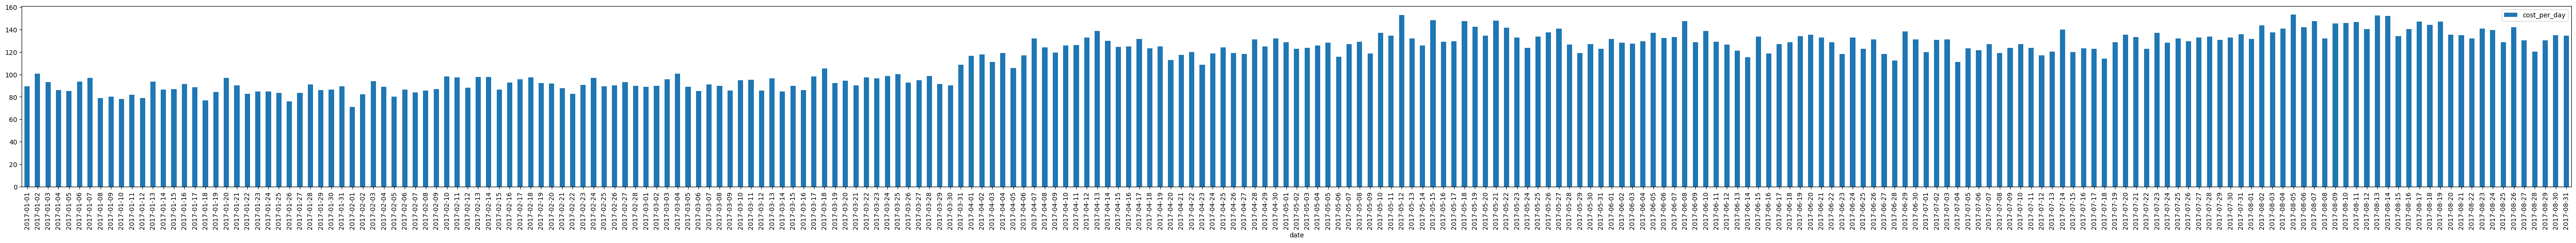

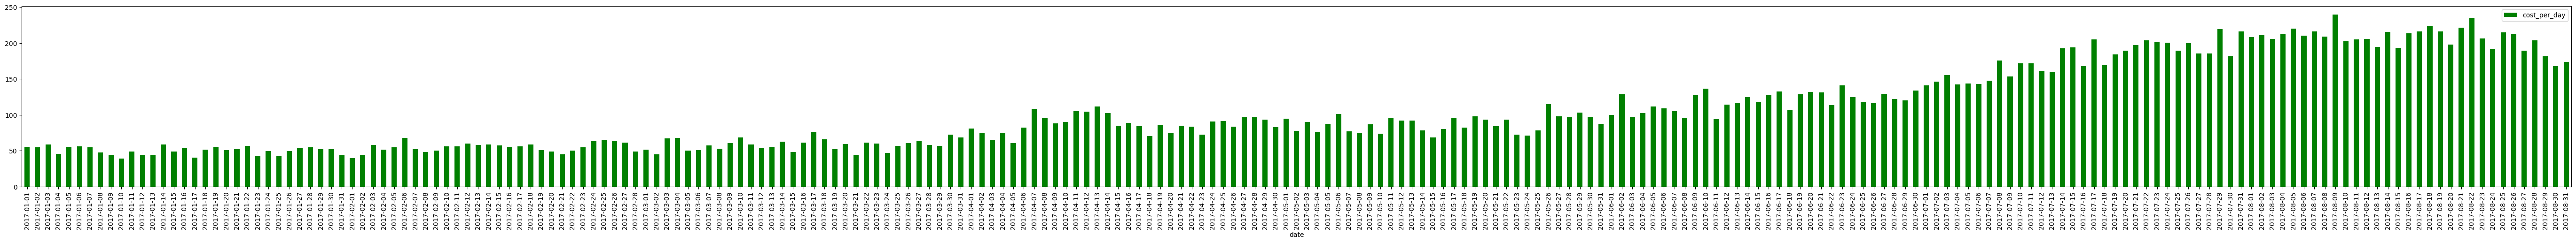

In [168]:
#Now we are going to compare data of 2017 (last time of data, but year is incomplete)
mask = df_price_per_day_pandas['date'].str.contains("2017") & df_price_per_day_pandas["hotel"].str.contains("Hotel")
df_price_per_day_pandas_2017 = df_price_per_day_pandas [mask]
df_price_per_day_pandas_2017.plot(kind="bar",x="date", y=["cost_per_day"])
#Same filter for Apartments
mask = df_price_per_day_pandas['date'].str.contains("2017") & df_price_per_day_pandas["hotel"].str.contains("Apartment")
df_price_per_day_pandas_2017 = df_price_per_day_pandas [mask]
df_price_per_day_pandas_2017.plot(kind="bar",x="date", y=["cost_per_day"],color='green')
plt.show()